In [1]:
import dgl
import numpy as np 
import pandas as pd
import torch

Using backend: pytorch


In [2]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dgl.nn.pytorch.conv.GraphConv(in_dim, hidden_dim,
                               norm='both', weight=True, bias=True)
        # self.act_fc = nn.ReLU()
        self.classify1 = nn.Linear(hidden_dim, n_classes)
    
    def forward(self, graph, n_feat):

        # 应用图卷积和激活函数
        h1 = self.conv1(graph, n_feat)
        # ac_h1 = self.act_fc(h1)
        
        #图读出阶段
        with graph.local_scope():
            graph.ndata['h'] = h1
            # 使用平均读出计算图表示
            hg = dgl.readout_nodes(graph, 'h', weight=None, op='mean', ntype=None)
            return self.classify1(hg)
    @property
    #原文链接：https://blog.csdn.net/beilizhang/article/details/111570443

    # 自己定义num_labels
    def num_labels(self):
        return 2

    def __getitem__(self, idx):
        return self.graphs[idx], self.label[idx]

    def __len__(self):
        return len(self.graphs)


In [5]:
u, v = torch.tensor([0, 0, 0, 1]), torch.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
g = dgl.add_self_loop(g)
g.edata['h'] = torch.ones(8,1)
g.ndata['h'] = torch.randn([u.shape[0],5])
label = torch.tensor([0])
g

Graph(num_nodes=4, num_edges=8,
      ndata_schemes={'h': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(1,), dtype=torch.float32)})

In [3]:
modle = Classifier(5, 6, 2)
opt = torch.optim.Adam(modle.parameters()) 

In [5]:
opt.zero_grad()

In [15]:
# # 不要运行
# loss.backward()
# opt.step()
# modle._modules['conv1']

In [12]:
def grad_hook(module, input, output):
    y_grad1.append(output[0].data.clone())
def forward_hook(module, input, output): # 记录输出
    act.append(output.data.clone())

y_grad1 = list()
act = list()
# aimlayer = modle._modules['conv1']
h = modle.conv1.register_backward_hook(grad_hook)#register_backward_hook(grad_hook)
act1 = modle.conv1.register_forward_hook(forward_hook)

logist = modle(g, g.ndata['h'])
loss = torch.nn.functional.cross_entropy(logist, label)

out = logist.data.clone()
out = out.zero_()
out = out.scatter_(1, label.unsqueeze(0).t(), 1.0)

opt.zero_grad()
logist.backward(out)
h.remove()

In [8]:
g.ndata['h'].requires_grad_(True)
logist = modle(g, g.ndata['h'])
loss = torch.nn.functional.cross_entropy(logist, label)

out = logist.data.clone()
out = out.zero_()
out = out.scatter_(1, label.unsqueeze(0).t(), 1.0)

opt.zero_grad()
logist.backward(out)

In [9]:
gg = g.ndata['h'].grad
gg

tensor([[-0.0092, -0.0385, -0.0732,  0.0304, -0.0566],
        [-0.0056, -0.0234, -0.0444,  0.0185, -0.0343],
        [-0.0043, -0.0182, -0.0346,  0.0144, -0.0267],
        [-0.0035, -0.0149, -0.0282,  0.0118, -0.0218]])

In [17]:
modle.classify1.weight[:]#, modle.conv1.bias

tensor([[ 0.1074,  0.2670,  0.3222,  0.1657,  0.3135, -0.1245],
        [-0.2711,  0.0710, -0.4007, -0.1996,  0.4067, -0.1692]],
       grad_fn=<SliceBackward>)

In [14]:
y_grad1[0],act[0]

(tensor([[ 0.0269,  0.0667,  0.0805,  0.0414,  0.0784, -0.0311],
         [ 0.0269,  0.0667,  0.0805,  0.0414,  0.0784, -0.0311],
         [ 0.0269,  0.0667,  0.0805,  0.0414,  0.0784, -0.0311],
         [ 0.0269,  0.0667,  0.0805,  0.0414,  0.0784, -0.0311]]),
 tensor([[ 0.3520,  0.5587,  0.1304,  0.3409, -0.1963, -0.0307],
         [-0.3531,  0.7818, -1.0333,  0.4034, -0.2436,  0.6526],
         [-0.4532,  0.3272, -0.8962,  0.3981,  0.0248,  0.5247],
         [ 0.6116,  0.8089,  0.0794, -0.3976, -0.9543,  0.1107]]))

In [23]:
y_gsoft

tensor([[0.1637, 0.1704, 0.1728, 0.1661, 0.1724, 0.1545],
        [0.1637, 0.1704, 0.1728, 0.1661, 0.1724, 0.1545],
        [0.1637, 0.1704, 0.1728, 0.1661, 0.1724, 0.1545],
        [0.1637, 0.1704, 0.1728, 0.1661, 0.1724, 0.1545]])

Text(33.0, 0.5, 'kind')

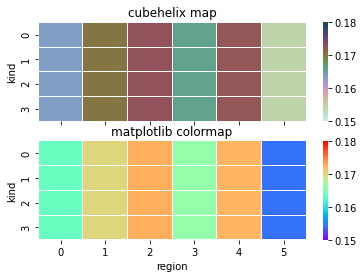

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
 
f, (ax1,ax2) = plt.subplots(figsize = (6,4),nrows=2)

y_gsoft = torch.softmax(y_grad1[0],dim = 1) 
# # cmap用cubehelix map颜色
# cmap = sns.cubehelix_palette(n_colors=6, start = 1, rot = 3, gamma=0.8, as_cmap = True)
# #pt = df.corr()   # pt为数据框或者是协方差矩阵
# sns.heatmap(y_gsoft.numpy(), linewidths = 0.05, ax = ax1, vmax=0.18, vmin=0.15, cmap=cmap)
# ax1.set_title('cubehelix map')
# ax1.set_xlabel('')
# ax1.set_xticklabels([]) #设置x轴图例为空值
# ax1.set_ylabel('kind')
 
# cmap用matplotlib colormap
sns.heatmap(y_gsoft, linewidths = 0.05, ax = ax2, vmax=0.18, vmin=0.15, cmap='rainbow') 
# rainbow为 matplotlib 的colormap名称
ax2.set_title('matplotlib colormap')
ax2.set_xlabel('region')
ax2.set_ylabel('kind')

In [9]:
cam = torch.mul(y_grad1[0],act[0])
cam = torch.sum(cam, dim= 1)
cam

tensor([ 0.0512, -0.0680, -0.0493,  0.0595])

In [10]:
cam1 = torch.softmax(cam, dim=0)

In [9]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([
    (0, 1),
    (1, 2),
    (2, 3),
    (1, 3),
])

pos = nx.drawing.random_layout(G)
print(pos)

{0: array([0.11430464, 0.73800945], dtype=float32), 1: array([0.3708748 , 0.16429374], dtype=float32), 2: array([0.09795629, 0.69697016], dtype=float32), 3: array([0.5811666, 0.8058247], dtype=float32)}


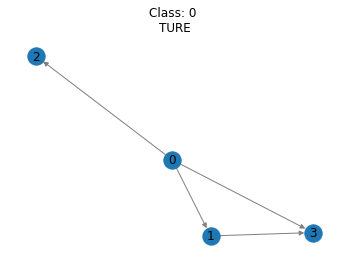

In [80]:
import matplotlib.pyplot as plt
import networkx as nx
from dataprocess import Arg

fig, ax = plt.subplots()
G = g.to_networkx()
pos=nx.spring_layout(G)
nx.draw(G,pos, edge_color="grey", node_size=300, with_labels=True)

ax.set_title("Class: {0} \nTURE".format(label[0]))

arg = Arg()
# plt.savefig(os.path.join(arg.cam_save_dir, "evaluate{0}.png").format(label[0])) 
plt.show()

In [17]:
G

In [21]:
# 测试cam
cam2 = torch.Tensor([[1,2,3],[2,2,2]])
cam1 = torch.softmax(cam2, dim=1)

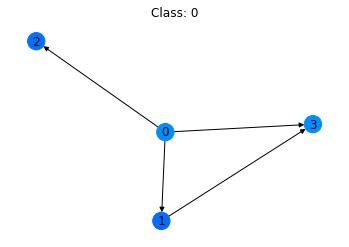

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import networkx as nx

jet = cm = plt.get_cmap('jet')
colorList = []
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
cam2 = cam1.tolist()
for value in cam1:
    colorVal = scalarMap.to_rgba(value)
    colorList.append(colorVal)

fig, ax = plt.subplots()
G = g.to_networkx()
pos=nx.spring_layout(G)
nx.draw(G,pos, node_color=colorList, node_size=300, with_labels=True)
ax.set_title('Class: 0')
plt.show()

In [17]:
rgba1 = list(colorList[1])
rgba1[]

[0.0, 0.42549019607843136, 1.0, 1.0]

In [19]:
arr = np.array([1, 3, 2, 4, 5])
arr.argsort()#[-3:][::-1]

array([0, 2, 1, 3, 4], dtype=int64)

In [28]:
cam3 = cam.numpy()
index = cam3.argsort() #[-3:][::-1]
cam3, index

(array([ 0.05119218, -0.06804662, -0.04929601,  0.05945616], dtype=float32),
 array([1, 2, 0, 3], dtype=int64))

In [93]:
cam3.shape

(4,)

In [89]:
rgba_vl = [255/256, 0., 0., 0.]
alsort = np.ones((4,4), dtype=np.float32)
size_v = 0
rank = np.ones(4,dtype= np.float32)
for i in index:
    rgba_vl[3] = rgba_vl[3] + (55/255) 
    alsort[i,:] = rgba_vl
    size_v+= 200
    rank[i] = size_v 
# alsort = torch.softmax(torch.tensor(alsort,dtype= torch.float32), dim=0).numpy()
alsort, rank

(array([[0.99609375, 0.        , 0.        , 0.64705884],
        [0.99609375, 0.        , 0.        , 0.21568628],
        [0.99609375, 0.        , 0.        , 0.43137255],
        [0.99609375, 0.        , 0.        , 0.8627451 ]], dtype=float32),
 array([600., 200., 400., 800.], dtype=float32))

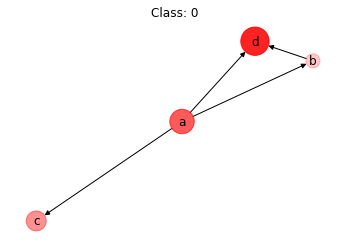

In [97]:
colorList = list()
# for value in alsort:
#     colorVal = scalarMap.to_rgba(value)
#     colorList.append(colorVal)

fig, ax = plt.subplots()
G = g.to_networkx()
pos=nx.spring_layout(G)
#pos = {'A1':np.array([0,1]),'A2':np.array([1,0]),'A3':np.array([0,0]),'A4':np.array([1,1])}
nx.draw(G, pos, node_color=alsort, node_size=rank, with_labels=True, labels = {0:'a',1:'b',2:'c',3:'d'})
ax.set_title('Class: 0')
plt.show()

In [92]:
cam5 = cam/torch.sum(cam, dim = 0)
cam5

tensor([-7.6471, 10.1649,  7.3639, -8.8816])